In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import cleantools as clnt
import mapping_tool as mt

all_sheets = clnt.loadPickle("../data/pickles/all_sheets.pkl")

In this notebook, I will explore various properties of the data set, and plot the results as much as possible.

# Number of Contracts #

Here I plot the number of contracts with different intervals, year by year, decade by decade, etc..

In [119]:
# Load frames
contracts = clnt.loadPickle("../data/pickles/clean_contracts.pkl")
contracts.columns = ["Contract Date"]

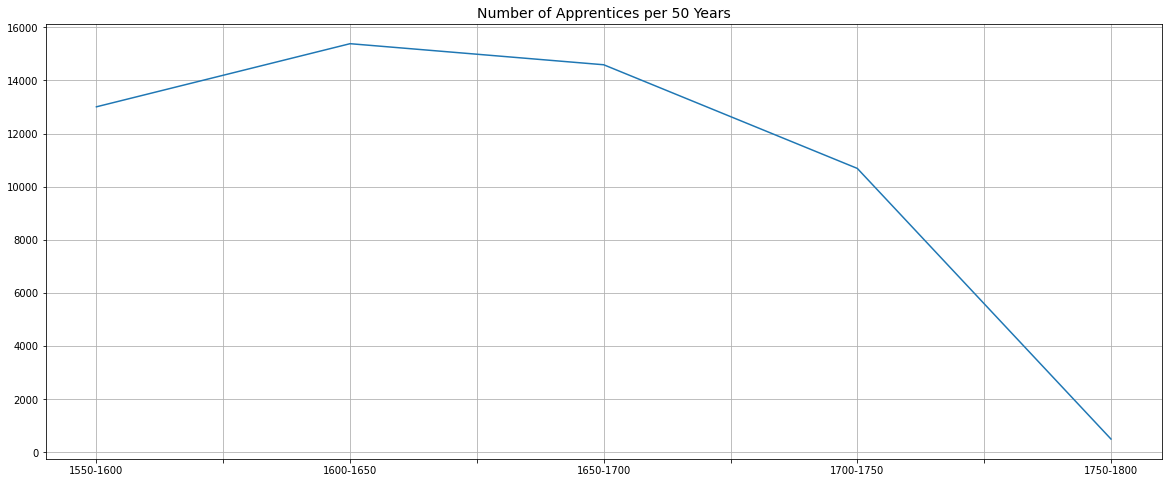

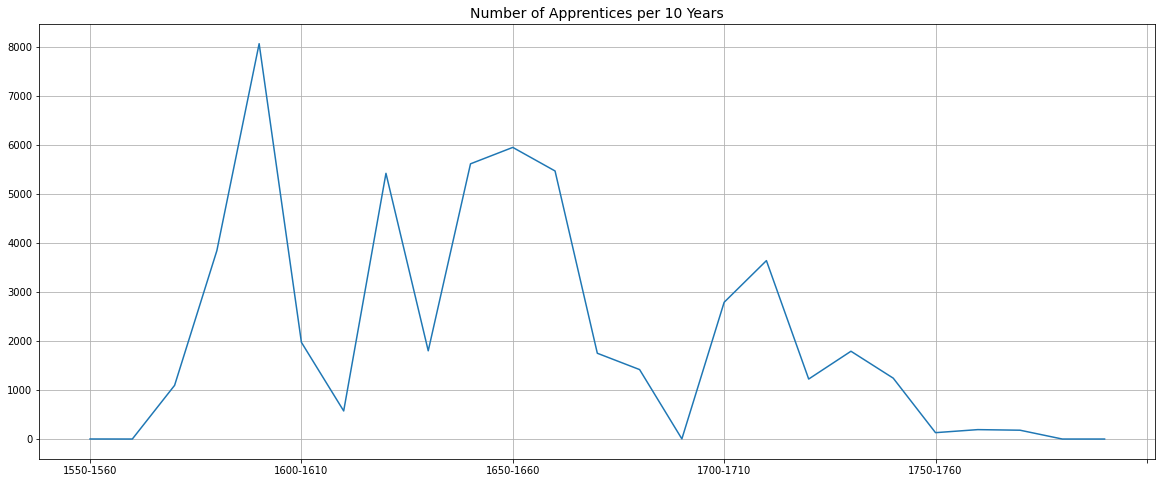

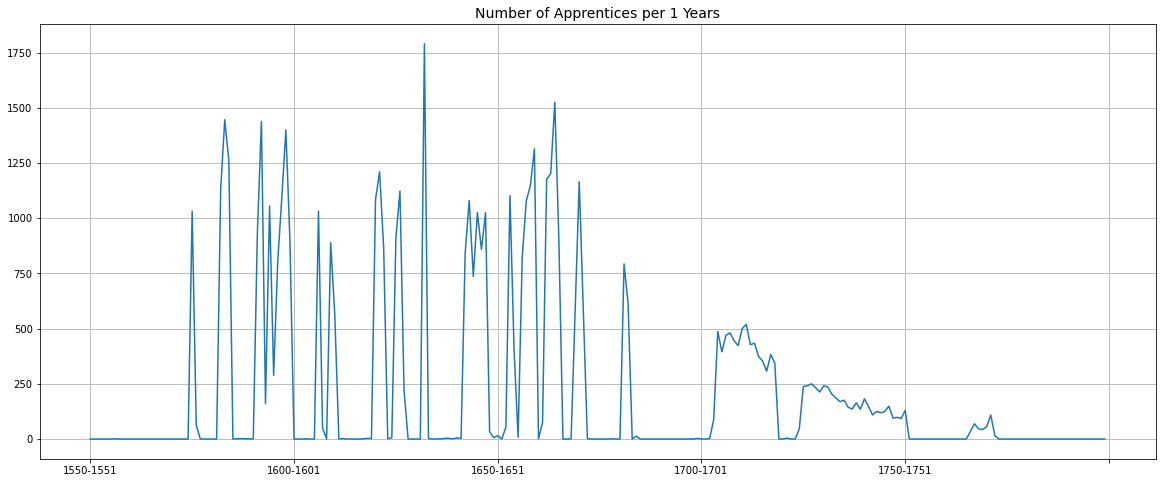

In [121]:
def contractCountGraph(prov_sec_prof, gap, start=1550, end=1800, **kwargs):
    """Takes in a dataframe, a year gap, and plots the number of contracts"""
    df = pd.DataFrame(columns = ["Apprentice Count"])
    # Populate the frame
    for year in range(start, end, gap):
        temp = clnt.betweenYears(prov_sec_prof, year, e_year = year + gap)
        df.loc[f"{year}-{year+gap}"] = len(temp)
    
    # Plot
    _, ax = plt.subplots(figsize=(20, 8))
    ax.set_title(f"Number of Apprentices per {str(gap)} Years", fontsize=14)
    df.plot(kind="line", legend=False, ax = ax, grid=True, **kwargs)
    plt.show()

# Plot various examples
contractCountGraph(contracts, 50)
contractCountGraph(contracts, 10)
contractCountGraph(contracts, 1)

# Age Distribution of Apprentices #

Here I do a basic plotting of ages on apprentices.

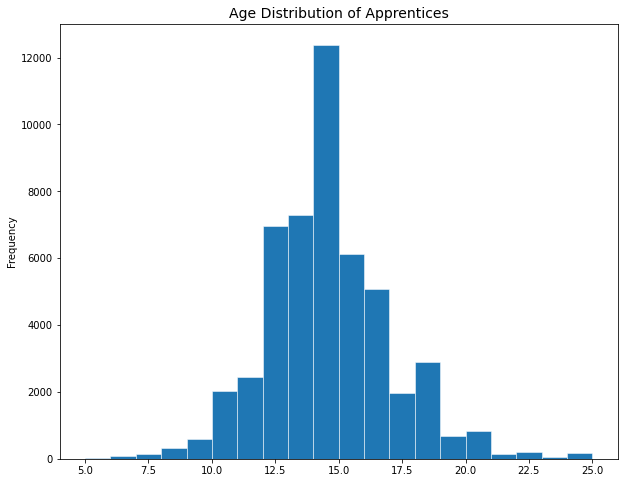

In [17]:
# Load the data set, select apprentices
person_mentions = clnt.loadPickle("../data/pickles/clean_mentions.pkl")
person_mentions = person_mentions[person_mentions["Tag"] == "grz:Apprentice"]

# Plot distribution
_, ax = plt.subplots(figsize=(10,8))
ax.set_title("Age Distribution of Apprentices", fontsize=14)
person_mentions["Age - Standard Form"].dropna().astype(int).plot.hist(ax=ax, range=[5,25], bins=20,
                                                                      edgecolor='white', linewidth=0.5)
plt.show()

# Payment Distribution #

Here, I try to change the total payment apprentices received into a similar currency to have a better understanding. Since this is a superficial way of analyzing, due to fluctuations in the value of a coin, it should not be used as a strong indicator of some correlation, but more of a result to tinker on.

In [6]:
# Load data frame
financial_info = all_sheets["Financial Conditions"].copy()

# Convert all the currencies to soldi
financial_info["Total - Standard Form"] = financial_info["Total Amount"] * financial_info[
    "Currency"
].apply(lambda x: clnt.currencyMap(x))
financial_info["Partial - Standard Form"] = financial_info["Partial Amount"] * financial_info[
    "Currency"
].apply(lambda x: clnt.currencyMap(x))

# Save the results
# clnt.savePickle(financial_info, "../data/pickles/clean_Financial.pkl")

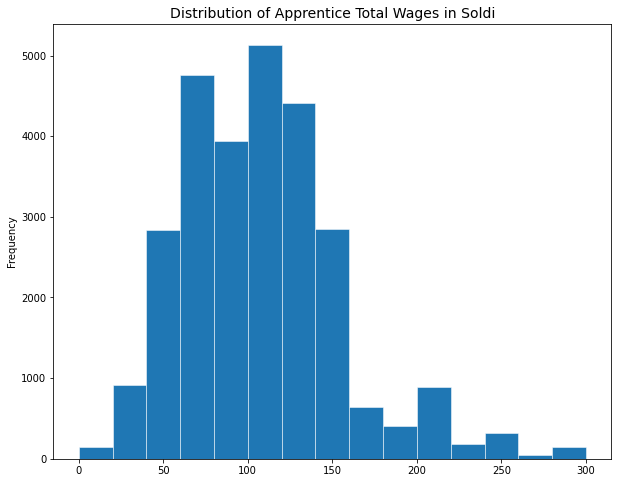

In [15]:
# Here, we only take prices not in goods, and paid by master
clean_money = financial_info[financial_info["Paid in Goods"] == False]
clean_money = clean_money[clean_money["Paid by"] == "grz:MasterPayer"]

# After some experiment, this seems to be the best rate for visualization
_, ax = plt.subplots(figsize=(10,8))
ax.set_title("Distribution of Apprentice Total Wages in Soldi", fontsize=14)
clean_money.loc[clean_money["Total - Standard Form"] > 0,
                "Total - Standard Form"].plot.hist(ax=ax, 
                                                   range=[0, 300],
                                                   edgecolor='white',
                                                   linewidth=0.5, bins=15)
plt.show()

# Average Age per Job Label #

Here I compare the average ages of apprentices per job label, to see if there is a trend. I only take top 10 most crowded jobs, but this code can easily be tweaked to do more.

In [38]:
# Load the necessary dataframes
mentions = clnt.loadPickle("../data/pickles/clean_mentions.pkl")[["Age - Standard Form",
                                                                  "Professions - Standard Form"]]
categories = clnt.loadPickle("../data/pickles/clean_professions_trimmed.pkl")[["Standard Form", "Parent Label"]]


In [40]:
# Get Parent Label from Categories
temp = pd.merge(mentions, categories,
                left_on="Professions - Standard Form",
                right_on="Standard Form")[["Age - Standard Form", "Parent Label"]]

# Convert column to numbers
temp["Age - Standard Form"] = pd.to_numeric(temp["Age - Standard Form"])

# Group according to label, filter outliers
grouped_age = temp.groupby(["Parent Label"]).agg(["mean", "count"])
plot_worth = grouped_age[(grouped_age[("Age - Standard Form", "mean")] > -1) &
                         (grouped_age[("Age - Standard Form", "count")] > 20)].sort_values(("Age - Standard Form", "count"), ascending=False)

# Save for further usage
# clnt.savePickle(grouped_age, "../data/pickles/age_with_prof_categories.pkl")

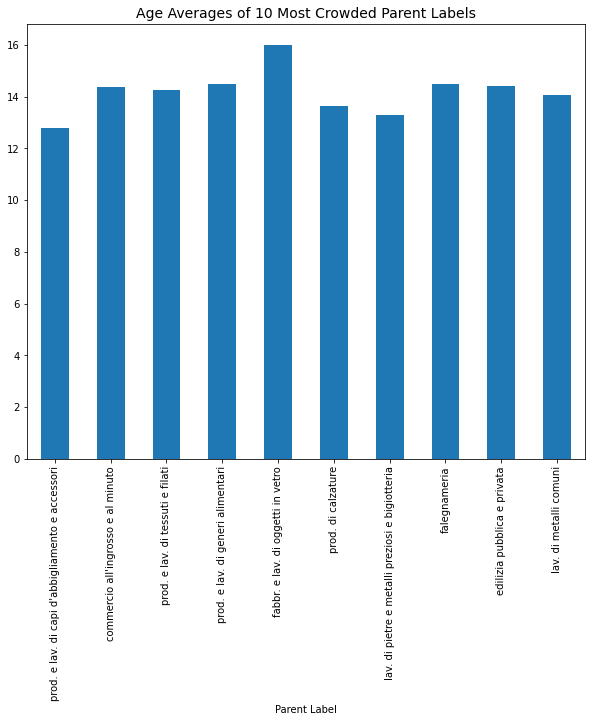

In [42]:
# Plot the top 10 
_, ax = plt.subplots(figsize=(10, 8))
ax.set_title("Age Averages of 10 Most Crowded Parent Labels", fontsize=14)
plot_worth[[("Age - Standard Form", "mean")]][:10].plot(kind="bar", ax=ax, 
                                                        legend=False)
plt.show()

# Geo Origin Counts Against Job Label #

Here I make a data structure that maps Job Labels to geo origin counts. This structure can be used for plottings and comparison

In [44]:
# Load data frame
mentions = clnt.loadPickle("../data/pickles/clean_mentions.pkl")[["Geo Origin - Standard Form",
                                                                  "Professions - Standard Form"]]
categories = clnt.loadPickle("../data/pickles/clean_professions_trimmed.pkl")[["Standard Form", 
                                                                               "Parent Label"]]

In [84]:
# Merge Frames to get Parent Label
temp = pd.merge(mentions,
                categories,
                left_on="Professions - Standard Form",
                right_on="Standard Form")[["Geo Origin - Standard Form",
                                           "Parent Label"]]
# Use pandas grouping for double indexing
groups = temp.groupby("Parent Label").apply(lambda x:x.groupby("Geo Origin - Standard Form").count())
groups.columns = ["Geo Origin Counts"]

# Save structure
# clnt.savePickle(groups, "../data/pickles/profession_labels_with_province_counts_dict.pkl")

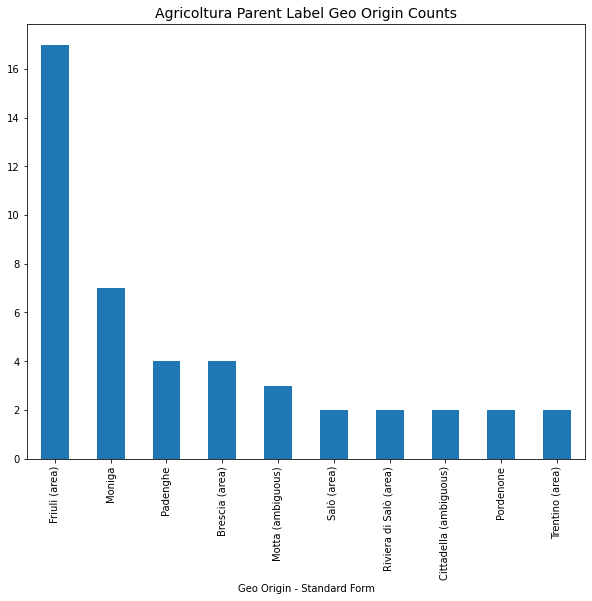

In [92]:
# Plot the graph
_, ax = plt.subplots(figsize=(10,8))
ax.set_title("Agricoltura Parent Label Geo Origin Counts", fontsize=14)
groups.loc["agricoltura"].sort_values("Geo Origin Counts",
                                      ascending=False)[:10].plot(kind="bar", ax=ax,
                                                                 legend=False)
plt.show()

# Profession's Affect on Final Payment #

Here I check the statistics on profession and payment, to see possible correlations.

In [100]:
# Load dataframes
mentions = clnt.loadPickle(
    "../data/pickles/clean_mentions.pkl"
)[["Contract ID", "Professions - Standard Form", "Tag"]]

finances = clnt.loadPickle(
    "../data/pickles/clean_Financial.pkl"
)[["Contract ID", "Total - Standard Form"]]

categories = clnt.loadPickle(
    "../data/pickles/clean_professions_trimmed.pkl"
)[["Standard Form", "Parent Label"]]

# Get Apprentices only
apprentices = mentions[mentions["Tag"] == "grz:Apprentice"]

apprentices = apprentices.merge(categories,
                                left_on="Professions - Standard Form",
                                right_on="Standard Form")

jobs_w_pays = apprentices.merge(finances, on="Contract ID")[["Parent Label", "Total - Standard Form"]]
jwp_grouped = jobs_w_pays.groupby(["Parent Label"]).agg(["mean","count"])
jwp_grouped
jwp_grouped[(jwp_grouped[("Total - Standard Form", "count")] > 5) &
            (jwp_grouped[("Total - Standard Form", "mean")] > 1)].sort_values(("Total - Standard Form", "mean"),
                                                                              ascending=False).head(10)

Total - Standard Form      
                                                             mean count
Parent Label                                                           
fabbr. di strumenti musicali                           409.821429    28
prod. e lav. di bevande                                249.615385    13
fabbr. e lav. della carta                              214.875000    80
farmacia e spezieria                                   127.607053   794
fabbr. e lav. di oggetti in vetro                      111.950594  3198
intaglio, cesellatura, molatura e tornitura            104.258555   526
prod. di colori                                        103.071429   140
commercio all'ingrosso e al minuto                     101.687282  4584
scultura                                               100.000000    19
pesca                                                   99.772727   242

# Age's Effect on Income #

Here I plot age against income, standardized in soldi again.

In [ ]:
# Get necessary dataframes
mentions = clnt.loadPickle("../data/pickles/clean_mentions.pkl")[["Contract ID",
                                                                  "Tag",
                                                                  "Age - Standard Form"]]
finances = clnt.loadPickle("../data/pickles/clean_Financial.pkl")[["Contract ID",
                                                                   "Total - Standard Form",
                                                                   "Paid by"]]
# Trim to only apprentices
apprentices = mentions[mentions["Tag"] == "grz:Apprentice"]

# Merge
age_w_money = pd.merge(apprentices, finances, on="Contract ID")

# Fix data type
age_w_money["Age - Standard Form"] = pd.to_numeric(age_w_money["Age - Standard Form"])

# Base only on master payments
age_w_money = age_w_money[age_w_money["Paid by"] == "grz:MasterPayer"][["Age - Standard Form",
                                                                        "Total - Standard Form"]]
# Group to get means
age_w_money = age_w_money.groupby(["Age - Standard Form"]).agg(["mean", "count"]).reset_index()
awm_trimmed = age_w_money[(age_w_money[("Total - Standard Form", "count")] > 500) &
                          (age_w_money[("Total - Standard Form", "mean")] > 0)]

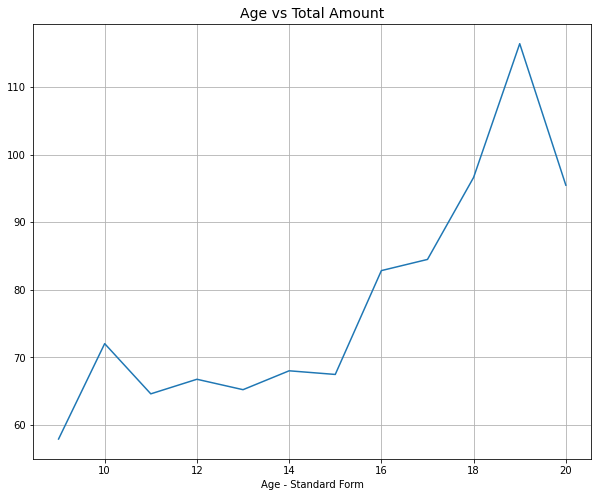

In [123]:
_, ax = plt.subplots(figsize=(10,8))
ax.set_title("Age vs Total Amount", fontsize=14)
awm_trimmed.plot.line("Age - Standard Form", ("Total - Standard Form", "mean"), ax=ax, legend=False, grid=True)
plt.show()

Now, I normalize the income with the period it was given, to get a yearly estimation.

In [117]:
# Load dataframes
events = clnt.loadPickle("../data/pickles/clean_events.pkl")

# Merge
age_w_money = pd.merge(apprentices, finances, on="Contract ID")
age_w_money = age_w_money.merge(events, on="Contract ID")

# Exclude unnecessary sections, and adjust to time
awm_timed = age_w_money[age_w_money["Paid by"] == "grz:MasterPayer"]
awm_timed = awm_timed[(awm_timed["Duration - Merged"] > 0) &
                      (awm_timed["Total - Standard Form"] < 9999999)]

awm_timed["Yearly"] = awm_timed["Total - Standard Form"] / awm_timed["Duration - Merged"] * 365
awm_timed = awm_timed[["Age - Standard Form", "Yearly"]]

# Group the values accordingly
awm_grouped = awm_timed.groupby(["Age - Standard Form"]).agg(["mean", "count"]).reset_index()
awm_grouped = awm_grouped[(awm_grouped[("Yearly", "mean")] > 0) &
                          (awm_grouped[("Yearly", "mean")] < 9999999) &
                          (awm_grouped[("Yearly", "count")] > 450)]

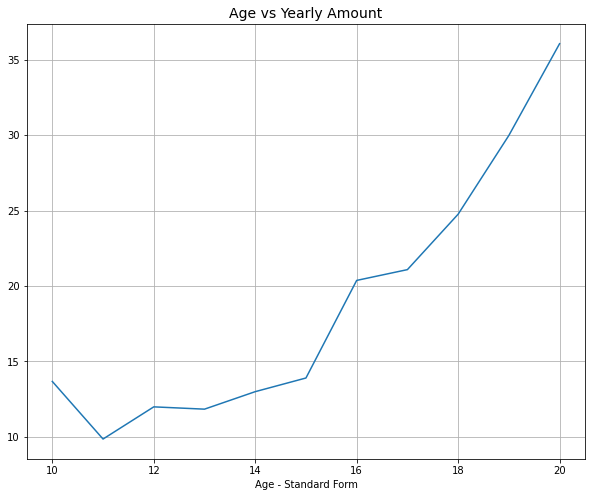

In [124]:
# Plot
_, ax = plt.subplots(figsize=(10, 8))
ax.set_title("Age vs Yearly Amount", fontsize=14)
awm_grouped.plot.line("Age - Standard Form", ("Yearly", "mean"), ax=ax, legend=False, grid=True)
plt.show()

# Province Counts against Sectors and Top Sector Professions #

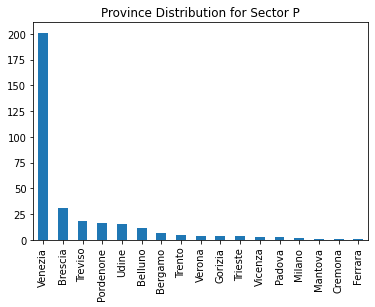

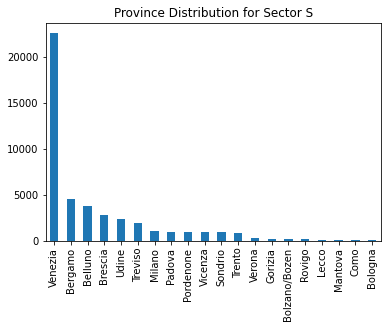

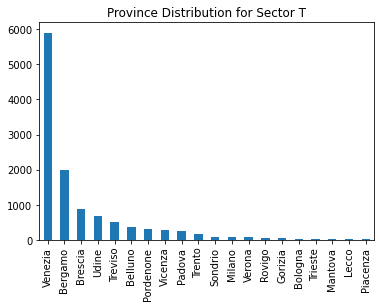

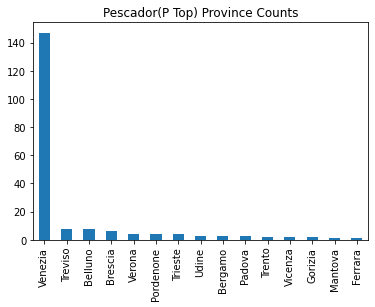

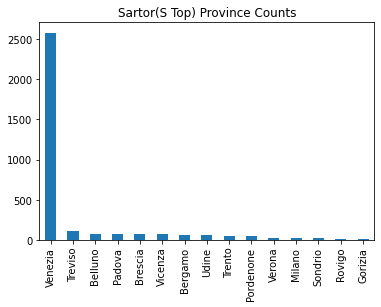

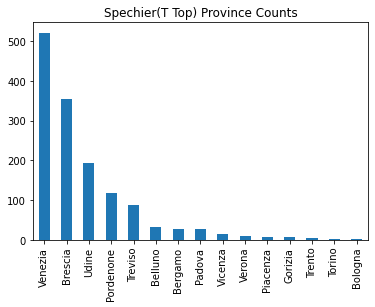

In [126]:
# Load frame, get sectors as constants
provenance_sector_profession = clnt.loadPickle(
    "../data/pickles/table_of_all.pkl"
)[["Apprentice Province", "Apprentice Profession", "Contract Date",
   "P", "S", "T"]].copy()

sectors = ["P", "S", "T"]

# Get the plots
for sector in sectors:
    st = provenance_sector_profession[provenance_sector_profession[sector] == 1][["Apprentice Province", "Apprentice Profession"]]
    st['Apprentice Province'].value_counts()[:20].plot(kind='bar', title=f"Province Distribution for Sector {sector}")
    plt.show()
    
for sector in sectors:
    st = provenance_sector_profession[provenance_sector_profession[sector] == 1][["Apprentice Province", "Apprentice Profession"]]
    st_top = st["Apprentice Profession"].value_counts().index[0]
    st_top_df = provenance_sector_profession[provenance_sector_profession["Apprentice Profession"] == st_top][["Apprentice Province"]]
    st_top_df["Apprentice Province"].value_counts()[:15].plot(kind = 'bar', title = f"{st_top.title()}({sector} Top) Province Counts")
    plt.show()

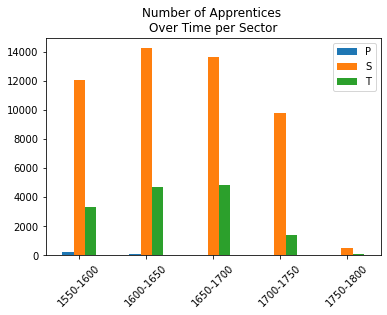

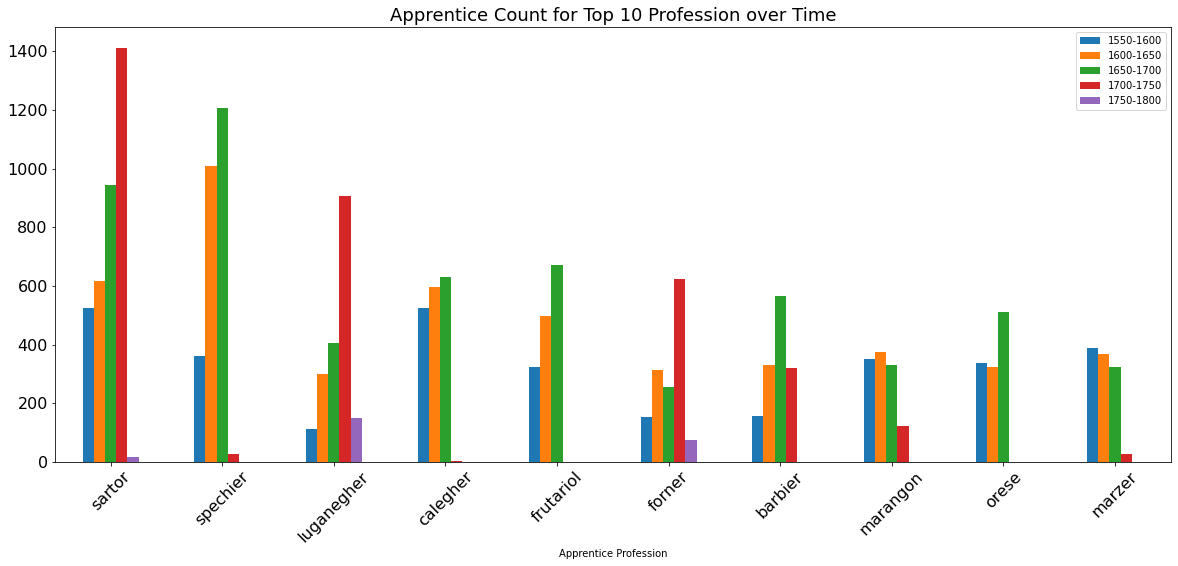

In [135]:
# Constants to define
start=1550
end=1800
gap=50

# Dataframe to store
df = pd.DataFrame(columns = ["P", "S", "T"])

# Loop through time intervals to store
for year in range(start, end, gap):
    temp = clnt.betweenYears(provenance_sector_profession, year, e_year = year + gap)
    df = df.append(pd.Series(temp[["P", "S", "T"]].sum(), name = f"{year}-{year+gap}"))

# Plot the results
df.plot(kind="bar", title="Number of Apprentices \nOver Time per Sector", rot=45)
plt.show()

# Similar process to professions
df = pd.DataFrame({"Apprentice Profession": provenance_sector_profession["Apprentice Profession"].unique()})
for year in range(start, end, gap):
    temp = clnt.betweenYears(provenance_sector_profession, year, e_year = year + gap)
    groups = temp.groupby("Apprentice Profession")[["Apprentice Profession"]].agg("count").copy()
    groups.columns = [f"{year}-{year+gap}"]
    df = df.merge(groups, on="Apprentice Profession", how = "left")

# Grouping
groups = provenance_sector_profession.groupby("Apprentice Profession")[["Apprentice Profession"]].agg("count").copy()
groups.columns = ["Total"]

# Sorting, indexing and plotting
df = df.merge(groups, on="Apprentice Profession", how = "left")
df = df[df["Apprentice Profession"].notna()]
df = df.set_index("Apprentice Profession")
_, ax = plt.subplots(figsize=(20,8))
ax.set_title("Apprentice Count for Top 10 Profession over Time", fontsize=18)
df.sort_values("Total", ascending = False)[:10][df.keys()[:-1]].plot(kind='bar',
                                                                     ax=ax,
                                                                     fontsize=16,
                                                                     rot=45,)
plt.show()

# Gender Against Tag #

In [ ]:
# Load Frames
tag_n_gender = clnt.loadPickle("../data/pickles/clean_mentions.pkl")[["Tag", "Gender", "Person ID"]].drop_duplicates("Person ID")

# Encode gender
gender_dum = clnt.hotEncode(tag_n_gender, tag_n_gender["Gender"], group="Person ID")

# Group by Tags to have a count
tag_n_gender = tag_n_gender.merge(gender_dum, on="Person ID").set_index("Person ID")
tag_groups = tag_n_gender.groupby("Tag").sum()

# Relable columns
tag_groups.columns = ["Female", "Male"]
tag_groups.index = [a[4:] for a in tag_groups.index.tolist()]

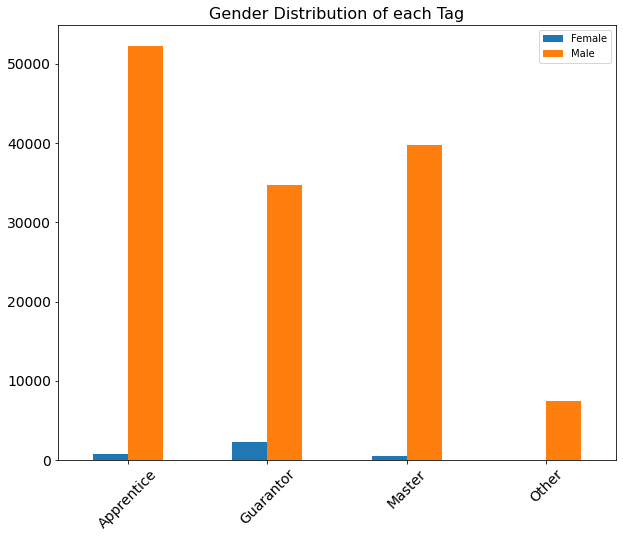

In [145]:
# Plot
_, ax = plt.subplots(figsize=(10,8))
ax.set_title("Gender Distribution of each Tag", fontsize=16)
tag_groups.plot(kind="bar", ax=ax, rot=45, fontsize=14)
plt.show()

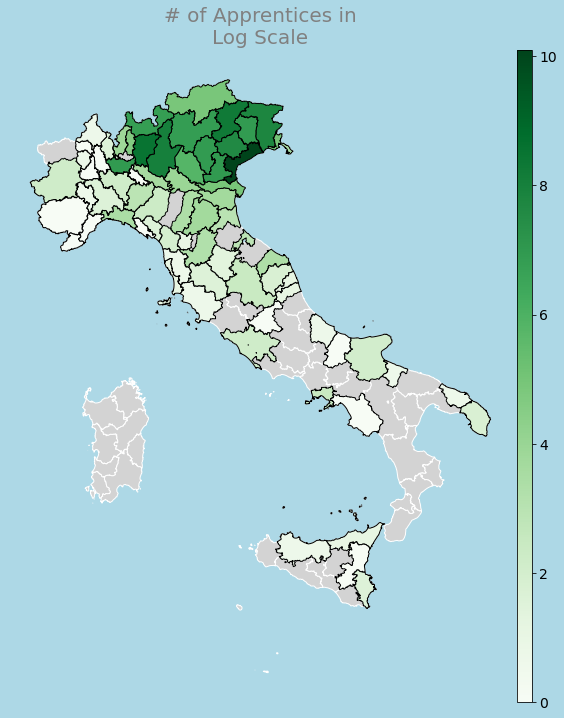

In [5]:
the_table = clnt.loadPickle("../data/pickles/table_of_all.pkl")
mt.filterNmap(the_table)

# Analysis of Categories #

Here I will use the column created in the Graph notebook called categories, which is a new column made from:

- The presence of a female in contract
- The apprentice being Venetian
- Anyone having a bond to the apprentice in relations

If the apprentice has a relation with anyone from the contract, the category number is incremented by 1. If there is a female party in the contract, the category number is incremented by 2. And finally, if the apprentice is Venetian, the category number is incremented by 4. Here is an example:

Let's say apprentice Ahmad has a contract with a master, and his mother is a guarantor in the contract. Ahmad is not from Venice. Therefore, Ahmad's contract is 1(has relation) + 2(guarantor is female) + 0(not Venetian) = 3 

In [ ]:
generated_categories = clnt.loadPickle("../data/pickles/generated_categories_appRel_femCon_fromVen.pkl")

## General Distribution ##

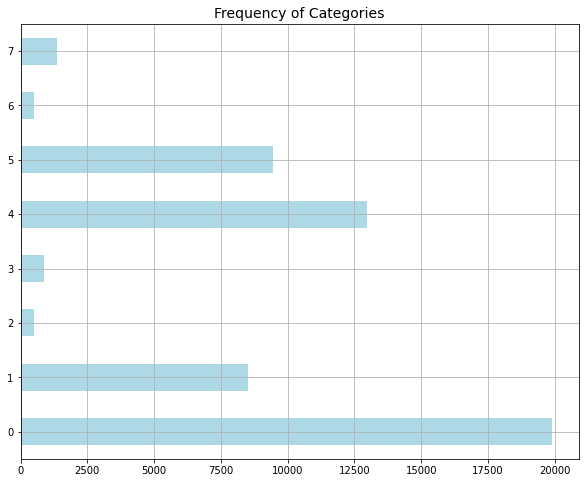

In [30]:
# We create dummies, then sum the counts, and plot them
_, ax = plt.subplots(figsize=(10,8))
ax.set_title("Frequency of Categories", fontsize=14)
generated_categories.Category.astype(
    str
).str.get_dummies().sum().plot(kind="barh", color="lightblue",
                               ax=ax, grid = True)
plt.show()

## Distribution over time ##

In [50]:
# Load dataframe
the_table = clnt.loadPickle("../data/pickles/table_of_all.pkl")

# Add time to category
generated_joined = the_table.join(generated_joined[["Category"]])

# Store over time in another frame
start = 1550
end = 1800
gap = 50
df = pd.DataFrame(columns = range(start, end, gap))
for year in range(start, end, gap):
    temp = clnt.betweenYears(generated_joined, year, e_year=year+gap)
    df[year] = temp.Category.astype(str).str.get_dummies().sum()

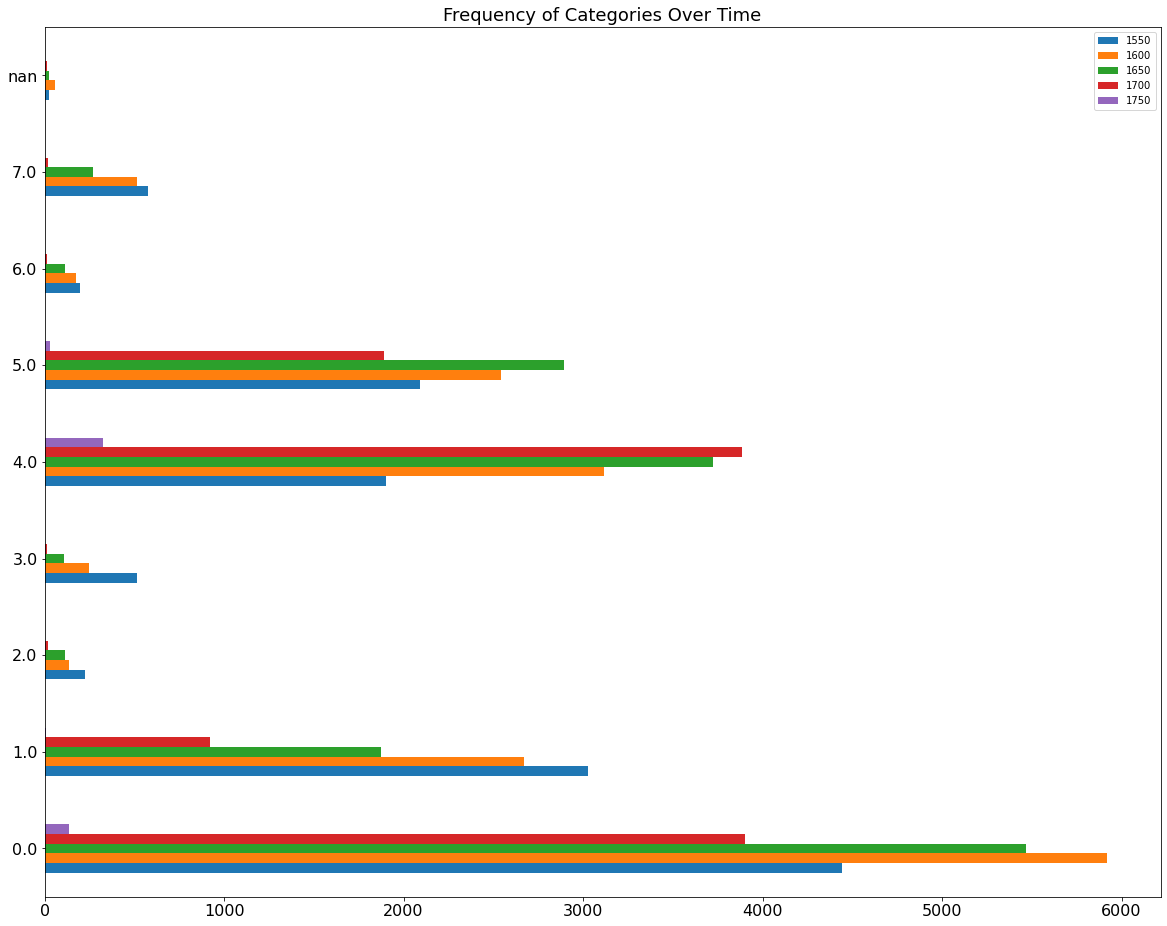

In [51]:
# Plot the results
_, ax = plt.subplots(figsize=(20,16))
ax.set_title("Frequency of Categories Over Time", fontsize=18)
df.plot(kind="barh", ax=ax, fontsize=16)
plt.show()

## Distribution over Sector ##

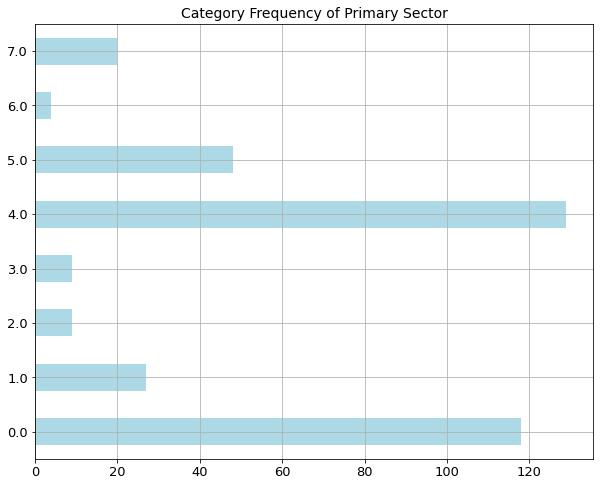

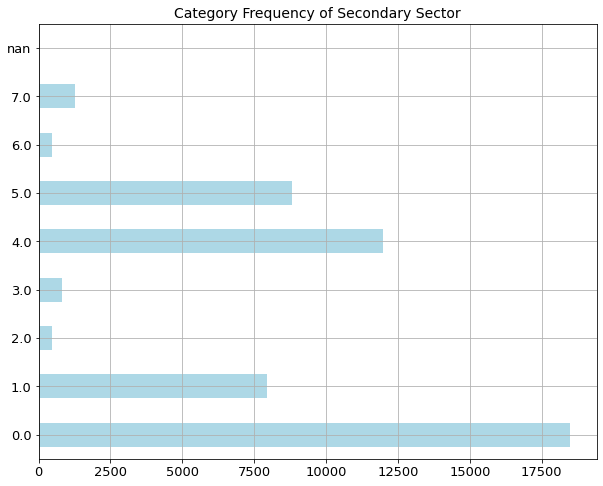

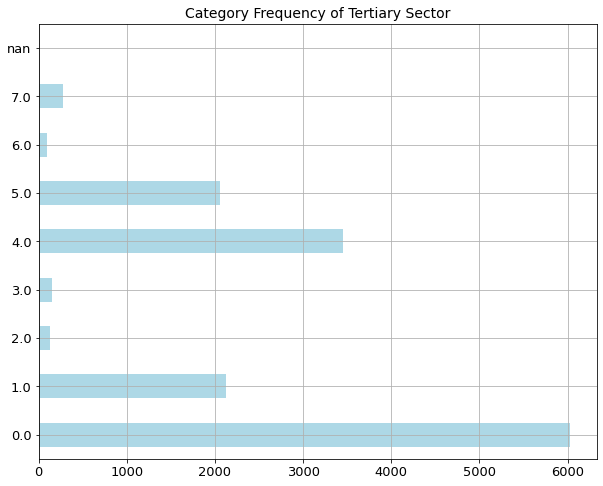

In [61]:
# df = pd.DataFrame()
for sector in ["Primary", "Secondary", "Tertiary"]:
    _, ax = plt.subplots(figsize=(10,8))
    ax.set_title(f"Category Frequency of {sector} Sector", fontsize=14)
    generated_joined.loc[generated_joined[sector[0]] == 1,
                         "Category"].astype(str).str.get_dummies().sum().plot.barh(ax=ax,
                                                                                   fontsize=13,
                                                                                   grid=True,
                                                                                   color="lightblue")
    plt.show()
# df["S"] = generated_joined.loc[generated_joined["S"] == 1, "Category"].astype(str).str.get_dummies().sum()
# df["T"] = generated_joined.loc[generated_joined["T"] == 1, "Category"].astype(str).str.get_dummies().sum()


## Profession distribution ##

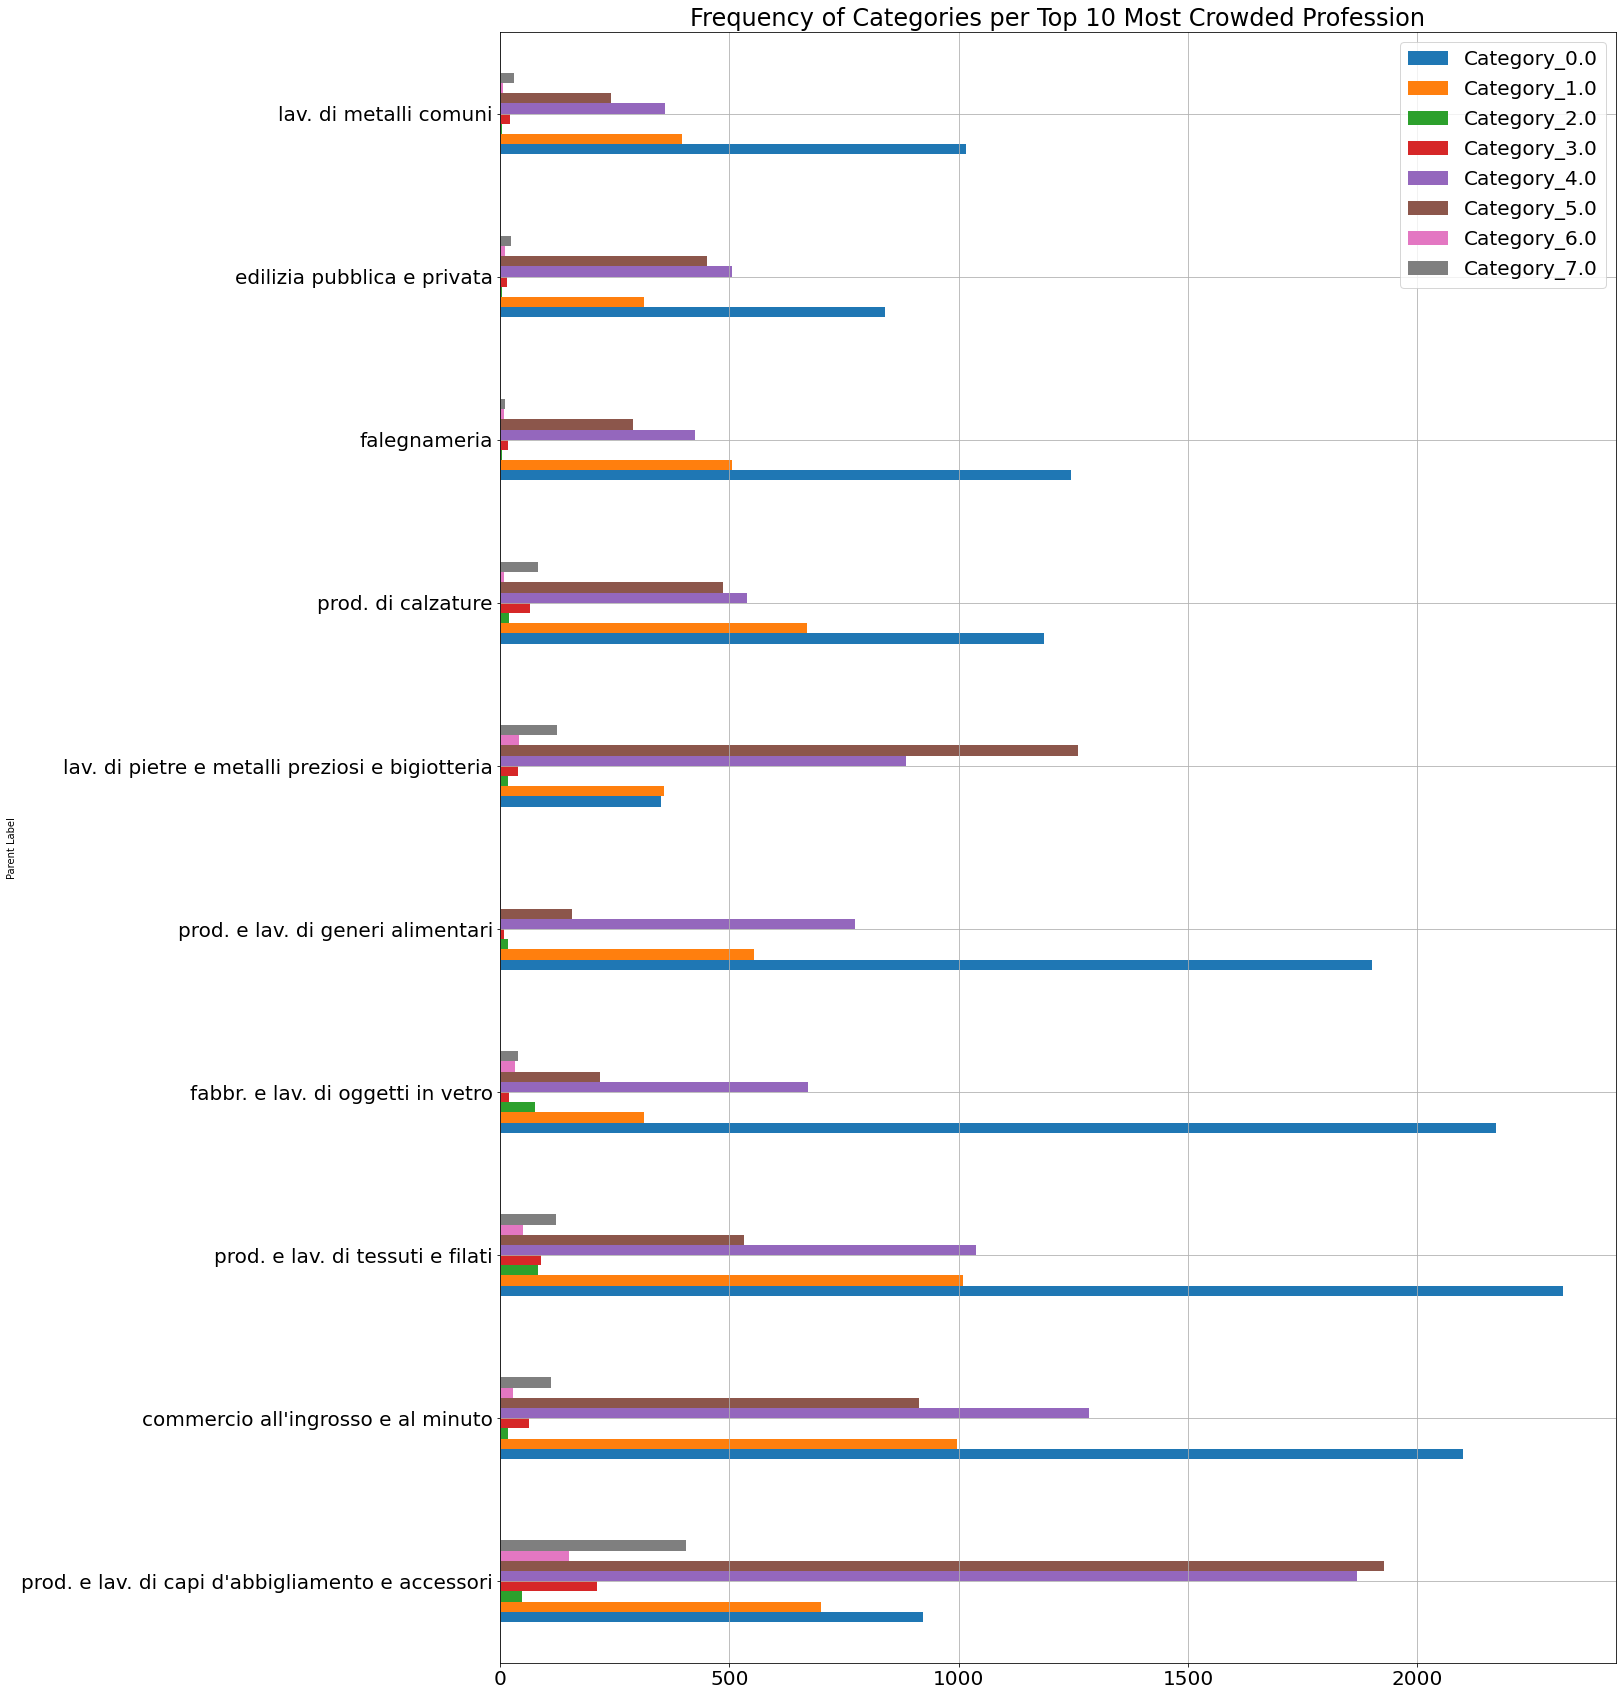

In [76]:
grouped = pd.get_dummies(generated_joined.reset_index()[["Parent Label", "Category"]], columns = ["Category"]).groupby("Parent Label").sum()
grouped["Sums"] = grouped.sum(axis=1)
sorted_grouped = grouped.sort_values("Sums", ascending=False)
del sorted_grouped["Sums"]
_, ax = plt.subplots(figsize=(20,30))
ax.set_title("Frequency of Categories per Top 10 Most Crowded Profession", fontsize=24)
sorted_grouped[:10].plot.barh(fontsize=20, grid=True, ax=ax)
plt.legend(fontsize=20)
plt.show()